# The Maximum Independent Set Problem

## Background

In graph theory, an independent set is a set of vertices in a graph such that no two of which are connected by an edge.
The problem of finding maximum independent sets (MIS) is NP-hard, i.e., it is unlikely to be solved in a time polynomial to the problem size.
Interestingly, there is a natural connection between the independent set constraint,
and the Rydberg Blockade phenomenon in neutral-atom quantum computing using Rydberg states.
More specifically, Rydberg blockade implies that two atoms cannot be both excited to the Rydberg state $|r\rangle$ if they are close to each other,
whereas independent set constraint means two vertices cannot be both in the independent set when they are connected by an edge.
Thus, one can consider atoms in the Rydberg state as vertices in an independent set. See the proposal in [H. Pichler, et al.](https://arxiv.org/pdf/1808.10816.pdf) for more details.

In particular, one can use the ground state of the Rydberg Hamiltonian to encode the [maximum independent set problem](https://en.wikipedia.org/wiki/Independent_set_(graph_theory)),
which is to find the largest independent set of a given graph.
For a particular subclass of geometric graphs, the so-called unit disk graphs,
the Rydberg Hamiltonian can encode the solution without any overhead in the number of qubits.
In fact, an experimental demonstration of quantum optimization has been realized in solving the maximum independent set problem up to 289 qubits in [S. Ebadi, et al.](https://arxiv.org/abs/2202.09372).

In this tutorial, we show how to solve the MIS problem using Bloqade.
We focus on a particular subclass of unit disk graphs defined as diagonal-connected unit-disk grid graphs (DUGG).
This is the class of graphs studied in the demonstration experiment [S. Ebadi, et al.](https://arxiv.org/abs/2202.09372).
Although these graphs have highly constraint topologies, finding its MISs is still NP-hard.
Here, we show how to use variational quantum algorithms with Rydberg Hamiltonians to solve the MIS problem on these graphs.
The tutorial here strongly resembles the setup in [S. Ebadi, et al.](https://arxiv.org/abs/2202.09372),
but, unsurprisingly, Bloqade can only simulate a much smaller problem.

For more details on the functionalities supported by Bloqade in studying independent set problems,
please refer to the MIS manual page.

Let's start by importing the required libraries:

In [32]:
using Pkg
Pkg.instantiate()

Precompiling project...
  ✓ PositiveFactorizations
  ✓ StatsAPI
  ✓ TropicalNumbers
  ✓ Suppressor
  ✓ BatchedRoutines
  ✓ PDMats
  ✓ IntegerMathUtils
  ✓ CommonSolve
  ✓ Combinatorics
  ✓ InverseFunctions
  ✓ BetterExp
  ✓ BFloat16s
  ✓ LazyModules
  ✓ Mods
  ✓ MicroMamba
  ✓ Distances
  ✓ Primes
  ✓ RandomNumbers
  ✓ OffsetArrays
  ✓ TimerOutputs
  ✓ ArrayInterface
  ✓ DensityInterface
  ✓ CloseOpenIntervals
  ✓ ArrayInterfaceOffsetArrays
  ✓ Random123
  ✓ LogExpFunctions
  ✓ CondaPkg
  ✓ MutableArithmetics
  ✓ StatsBase
  ✓ LLVM
  ✓ Polynomials
  ✓ StaticArrays
  ✓ SpecialFunctions
  ✓ DiffResults
  ✓ Contour
  ✓ ArrayInterfaceStaticArrays
  ✓ BitBasis
  ✓ GPUArrays
  ✓ MarchingCubes
  ✓ LuxurySparse
  ✓ FiniteDiff
  ✓ NearestNeighbors
  ✓ ArnoldiMethod
  ✓ StructArrays
  ✓ DiffRules
  ✓ DualNumbers
  ✓ Interpolations
  ✓ LayoutPointers
  ✓ GPUCompiler
  ✓ LabelledArrays
  ✓ ArrayInterfaceGPUArrays
  ✓ ColorVectorSpace
  ✓ ExponentialUtilities
  ✓ HypergeometricFunctions
  ✓ Bloqade

In [33]:
using Graphs
using Bloqade
using Compose
using Random
using GenericTensorNetworks
using Optim
using PythonCall
plt = pyimport("matplotlib.pyplot");

┌ Info: Precompiling Bloqade [bd27d05e-4ce1-5e79-84dd-c5d7d508bbe1]
└ @ Base loading.jl:1423
    CondaPkg Found dependencies: /Users/roger/.julia/environments/v1.7/CondaPkg.toml
    CondaPkg Found dependencies: /Users/roger/.julia/packages/Bloqade/OtpDb/CondaPkg.toml
    CondaPkg Found dependencies: /Users/roger/.julia/packages/PythonCall/XgP8G/CondaPkg.toml
    CondaPkg Dependencies already up to date
┌ Info: Precompiling GenericTensorNetworks [3521c873-ad32-4bb4-b63d-f4f178f42b49]
└ @ Base loading.jl:1423
┌ Info: Precompiling Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1423


## Setting Up the Problem

To begin, we create a $4*4$ DUGG with 0.8 filling, by using the `random_dropout` function.
Here, we choose the lattice constant $a$ to be 4.5 μm:

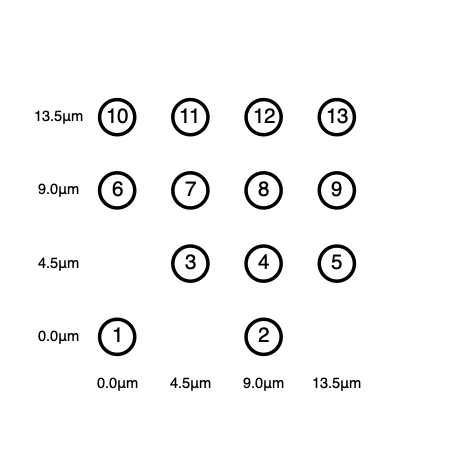

In [34]:
Random.seed!(2)
atoms = generate_sites(SquareLattice(), 4, 4; scale = 4.5) |> random_dropout(0.2)

Next, we set the blockade radius to be 7.5 μm,
corresponding to a case where nearest neighbors and next-nearest neighbors (diagonal) are within the blockade radius.
As we discussed in Rydberg Blockade, only one Rydberg excitation is allowed within the blockade radius.
To better illustrate this constraint, we
plot the interactions of Rydberg atoms as a DUGG, where each edge corresponds to the blockade constraint given by the blockade radius:

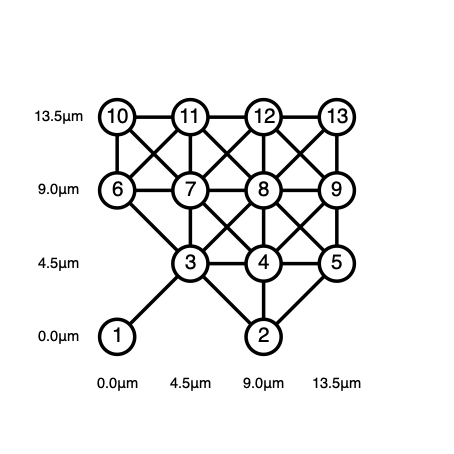

In [35]:
Bloqade.plot(atoms, blockade_radius = 7.5)

Our goal is to find a maximum independent set of such a graph.

For comparison, we first use classical algorithms to calculate the MIS size here using the graph utilities in Bloqade,
so that one can compare this exact result with the quantum algorithms.
The exact MIS size and its degeneracy can be solved with the generic tensor network algorithm in the package [`GenericTensorNetworks`](https://github.com/QuEraComputing/GenericTensorNetworks.jl):

In [36]:
graph = BloqadeMIS.unit_disk_graph(atoms, 7.5)
mis_size_and_counting = GenericTensorNetworks.solve(IndependentSet(graph), CountingMax())[]

(4.0, 26.0)ₜ

The `solve` function takes a graph instance and a solution space property as inputs,
where the graph instance is generated by the `unit_disk_graph` function in the module `BloqadeMIS`,
and the solution space property is to count the number of maximum independent sets here.
For this specific DUGG, we see that the MIS size is 4, and the number of maximum independent sets is 26.
In the following, we are going to show how to solve the independent set problem with both quantum adiabatic and variational algorithms.

## The Adiabatic Approach

Here, we generalize the quantum adiabatic algorithm used in
the tutorial Adiabatic Evolution to prepare ground states of the Rydberg Hamiltonian for this disordered lattice.
We first construct the adiabatic pulse sequences for the Rabi frequency $\Omega$ and the detuning $\Delta$:

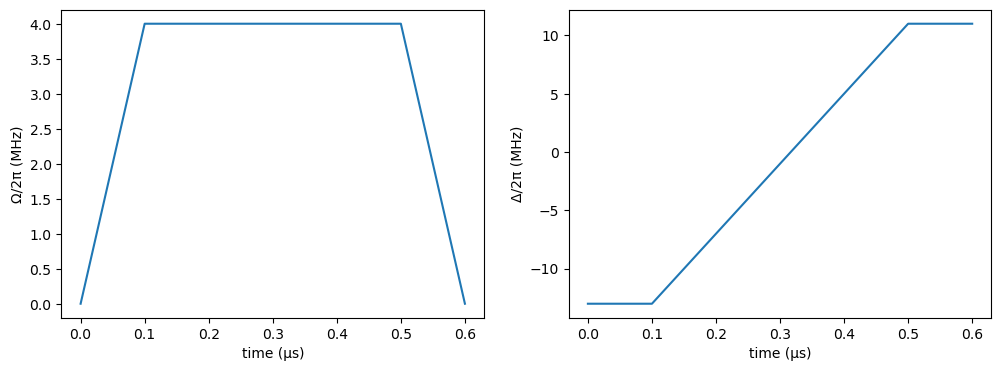

In [37]:
T_max = 0.6
Ω_max = 2π * 4
Ω = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [0.0, Ω_max, Ω_max, 0])
Δ_start = -2π * 13
Δ_end = 2π * 11
Δ = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [Δ_start, Δ_start, Δ_end, Δ_end])

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
fig

Here, the total time is fixed to `T_max`, the adiabatic evolution path is specified by the `piecewise_linear` function.
Rydberg blockade radius can be computed with
$$
C_6 / R_b^6 \sim \sqrt{\Delta^2 + \Omega^2}
$$
The default $C_6=2π * 862690 \text{ MHz μm}^6$.
For encoding the corresponding MIS problem at $\Omega = 0$,
the detuning can be set around $2\pi \times 11$ MHz
for a blockade radius of $7.5$ µm
(see the parameters in [S. Ebadi, et al.](https://arxiv.org/abs/2202.09372)).

Next, we create the time-dependent Hamiltonian and simulate its time evolution by using the `SchrodingerProblem` solver:

In [38]:
hamiltonian = rydberg_h(atoms; Ω = Ω, Δ = Δ)
prob = SchrodingerProblem(zero_state(nqubits(hamiltonian)), T_max, hamiltonian)
emulate!(prob)

SchrodingerProblem:
  register info:
    type: ArrayReg{2, ComplexF64, Matrix{ComplexF64}}
    storage size: 8 bytes

  time span (μs): (0.0, 0.6)

  equation: 
    storage size: 1.688 MiB
    expression:
nqubits: 13
+
├─ [+] ∑ 2π ⋅ 8.627e6.0/|r_i-r_j|^6 n_i n_j
├─ [+] Ω(t) ⋅ ∑ σ^x_i
└─ [-] Δ(t) ⋅ ∑ n_i


  options:
    save_everystep: false
    save_start: false
    save_on: false
    dense: false


Finally, we can plot the most probable bitstrings by using the `bitstring_hist` function on the resulting register (quantum state):

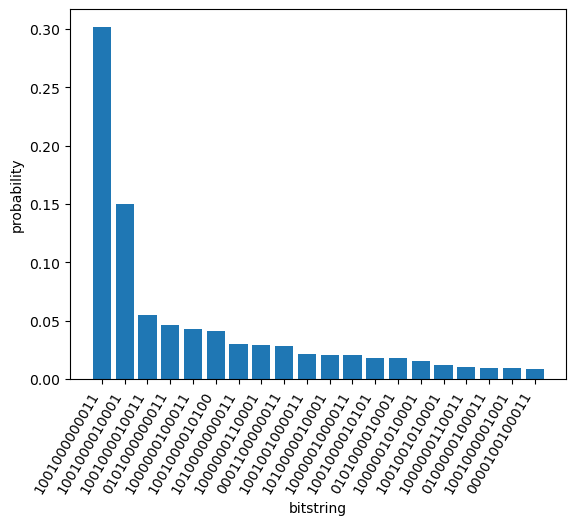

In [39]:
bitstring_hist(prob.reg; nlargest = 20)

We can see that some of the most probable configurations indeed have an independent set size 4 by counting the number of ones in the bitstring.
The correctness of the output can be verified by comparing it to the classical solution:

In [40]:
best_bit_strings = most_probable(prob.reg, 2)
all_optimal_configs = GenericTensorNetworks.solve(IndependentSet(graph), ConfigsMax())[]
@assert all(bs -> GenericTensorNetworks.StaticBitVector([bs...]) ∈ all_optimal_configs.c, best_bit_strings)

We can also visualize these atoms and check them visually:

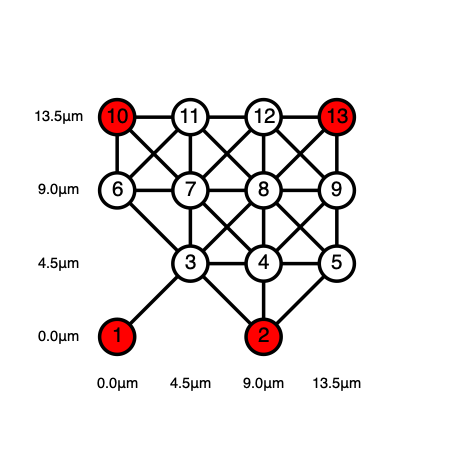

In [41]:
Bloqade.plot(atoms, blockade_radius = 7.5; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[1]])

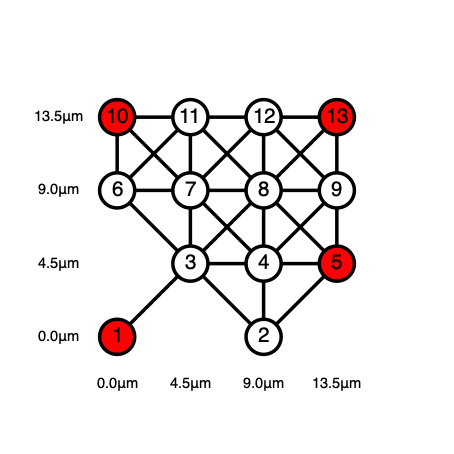

In [42]:
Bloqade.plot(atoms, blockade_radius = 7.5; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[2]])

However, there are still some configurations that violate the blockade constraint,
because the blockade interaction is not an ideal unit disk constraint (e.g. some bitstrings have a size 5).
One can check whether the independence constraint is satisfied or not with the `BloqadeMIS.is_independent_set` function:

In [43]:
best5_bit_strings = most_probable(prob.reg, 3)
BloqadeMIS.is_independent_set.(best5_bit_strings, Ref(graph))

3-element BitVector:
 1
 1
 0

This can happen when the Rydberg interaction is not very strong at the unit disk radius.
See the Rydberg Blockade page for more detailed explanations on Rydberg blockade
and its relation with the unit disk radius.
One can perform some postprocessing by reducing the violated configurations to indendendent set configurations
using the `mis_postprocessing` function. See the function documentation for more details on what it does.
Please also refer to the paper [S. Ebadi, et al.](https://arxiv.org/abs/2202.09372)
for more detailed discussion on the postprocessing procedure.

In [44]:
fixed = mis_postprocessing(best5_bit_strings[3], graph)
BloqadeMIS.is_independent_set(fixed, graph)

true

## QAOA with Piecewise Constant Pulses
The QAOA algorithm ([arxiv:1411.4028](https://arxiv.org/abs/1411.4028)) is a hybrid quantum-classical algorithm.
The classical part of the algorithm is an optimizer, which can be either a gradient-based or non-gradient-based one.
For our specific problem, the corresponding quantum part is a neutral-atom quantum computer
first evolving under the Rydberg Hamiltonian with parameterized pulse sequences and then being measured in the computational basis.

The standard definition of QAOA involves applying the problem (cost function) Hamiltonian $C$ and the transverse field Hamiltonian $B$ alternately.
Let $G=(V,E)$ be a graph. The cost Hamiltonian for an MIS problem can be defined as
$$
C(G) = -\sum_{j\in V}^{n} w_j n_j^z + \infty \sum_{\langle j,k\rangle \in E}n_j^z n_k^z
$$
where the first summation is proportional to the size of the independent set,
and the second term enforces the independence constraints.

In a Rydberg Hamiltonian, the first term corresponds to the detuning $w_i = \Delta$.
The second term contains an $\infty$, which corresponds to the Rydberg blockade term
with its strength described as $V_{jk} = C_6/|\overrightarrow{\mathbf{r_j}} - \overrightarrow{\mathbf{r_k}}|^6$.
As we can see, the Rydberg interaction is not a perfect independence constraint (with finite blockade interaction and unwanted long-rance interaction).
Thus, postprocessing might be required using neutral-atom quantum computers to solve the MIS problem.

The transverse field Hamiltonian corresponds to the Rabi term in the Rydberg Hamiltonian,
$$
B = \sum_{j=1}^{n}\sigma_j^x + \infty \sum_{\langle j,k\rangle \in E}n_j^z n_k^z.
$$

Note that the Rybderg interaction term is always on here
in contrast to the standard QAOA protocol.
For the convenience of the simulation, we use the `expect` function to get the averaged measurement outputs.
On the actual quantum hardware, the `expect` should be replaced by measuring in the computational basis
and obtaining the averaged number of Rydberg excitations as the loss function (also called objective function or cost function).
One can then either use non-gradient-based optimizers to perform the optimization
or use finite-difference methods to obtain gradients of parameters.

Let us first set up a non-optimized pulse sequences for QAOA with step $p=3$:

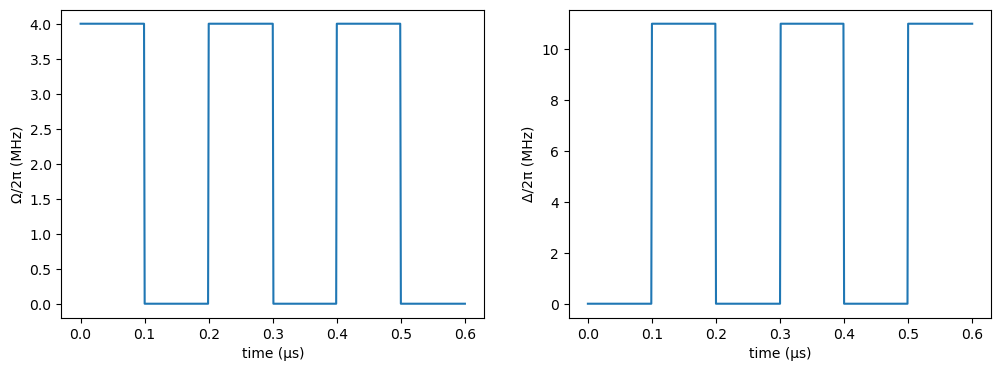

In [45]:
durations = fill(0.1, 6)
clocks = [0, cumsum(durations)...]
Ω2 = piecewise_constant(; clocks = clocks, values = repeat([Ω_max, 0.0], 3))
Δ2 = piecewise_constant(; clocks = clocks, values = repeat([0.0, Δ_end], 3))

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω2)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ2)
ax2.set_ylabel("Δ/2π (MHz)")
fig

The `piecewise_constant` pulses can be more accurately simulated with the `KrylovEvolution` solver.
This time, we simulate the dynamics in the subspace generated by the `blockade_subspace` function, so that we do not need postprocessing anymore.

In [46]:
hamiltonian2 = rydberg_h(atoms; Ω = Ω2, Δ = Δ2)
nsites = length(atoms)
subspace = blockade_subspace(atoms, 7.5)  # we run our simulation within the blockade subspace
prob2 = KrylovEvolution(zero_state(subspace), clocks, hamiltonian2)
emulate!(prob2);

We defined the loss function as the negative of the mean MIS size,
which corresponds to the expectation value of the `SumOfN` operator.
Thus, we can calculate the

average loss function after the time evolution:

In [47]:
loss_MIS(reg) = -rydberg_density_sum(prob2.reg)
loss_MIS(prob2.reg)

-2.562886912802683

The ouput shows the negative mean independent set size.
This is because we have flipped its sign since most optimizers are set to minimize the loss function.
This loss is equivalent to the `rydberg_density_sum` loss function in the `BloqadeMIS` module.
Alternative loss functions include the `gibbs_loss` and the `independent_set_probabilities`.

Here, the loss produced by these pulse sequences does not look very good.
We can throw it into an optimizer and see if a classical optimizer can help.
First, let us wrap up the above code into a loss function:

In [48]:
function loss_piecewise_constant(atoms::AtomList, x::AbstractVector{T}) where {T}
    @assert length(x) % 2 == 0
    Ω_max = 4 * 2π
    Δ_end = 11 * 2π
    p = length(x) ÷ 2

    # detuning and rabi terms
    durations = abs.(x)   # the durations of each layer of the QAOA pulse take the optimizing vector x as their input
    clocks = [0, cumsum(durations)...]
    Ωs = piecewise_constant(; clocks = clocks, values = repeat(T[Ω_max, 0.0], p))
    Δs = piecewise_constant(; clocks = clocks, values = repeat(T[0.0, Δ_end], p))

    hamiltonian = rydberg_h(atoms; Ω = Ωs, Δ = Δs)
    subspace = blockade_subspace(atoms, 7.5)  # we run our simulation within the blockade subspace
    prob = KrylovEvolution(zero_state(Complex{T}, subspace), clocks, hamiltonian)
    emulate!(prob)
    return -rydberg_density_sum(prob.reg), prob.reg
end

loss_piecewise_constant (generic function with 1 method)

!!! note
    Running the simulation in the subspace does not violate the independence constraints.
    If one uses fullspace simulation or runs it on the quantum computer, one may need to post-process the measured bit strings to a get a correct measure of the loss, if we don't set the blockade constraint.
    Related APIs include `is_independent_set`, `num_mis_violation`, and `mis_postprocessing`.

Let us check the loss function again using the initial point above:

In [49]:
x0 = durations
rydberg_density, reg1 = loss_piecewise_constant(atoms, x0)
rydberg_density

-2.562886912802683

The most probable bitstrings are:

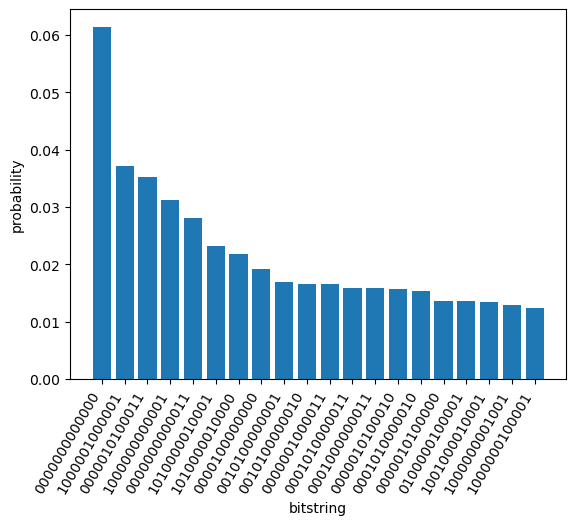

In [50]:
bitstring_hist(reg1; nlargest = 20)

We see that, without optimization, many of these bitstrings are not the MIS solutions.

Let us now use the non-gradient-based optimizer `NelderMead` in the `Optim` package to optimize the loss function:

In [51]:
optresult = Optim.optimize(x -> loss_piecewise_constant(atoms, x)[1], x0)

rydberg_density_final, reg1_final = loss_piecewise_constant(atoms, optresult.minimizer)
rydberg_density_final

-3.096591026001217

We see that the loss is indeed improved, but still not very good.
This is likely because the optimization is trapped in a local minimum.

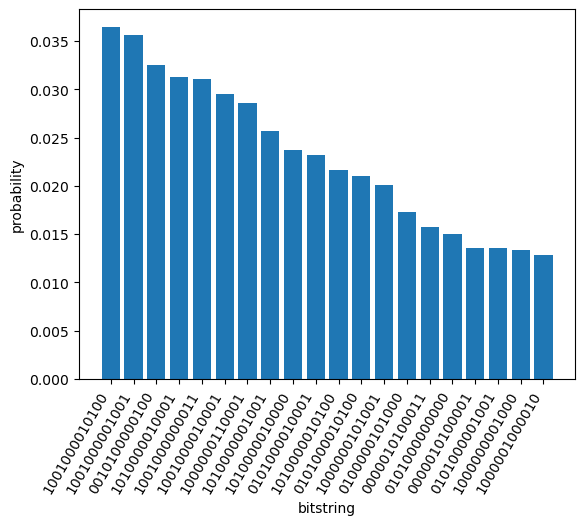

In [52]:
bitstring_hist(reg1_final; nlargest = 20)

This example shows that the performance of the algorithm very much depends on
the parametrization of the pulse sequences, the initialization of the variational parameters,
and the classical optimizers.
See [S. Ebadi, et al.](https://arxiv.org/abs/2202.09372)
for more in-depth comparison of different pulse parametrizations and tips on how to improve the performance.

In the example below, we show a better pulse parametrization
using smoothened piecewise linear waveforms.

## Smoothened Piecewise Linear Pulses

A smoothened piecewise linear waveform can be created by applying a Gaussian filter on a waveform created by the `piecewise_linear` function.
For example:

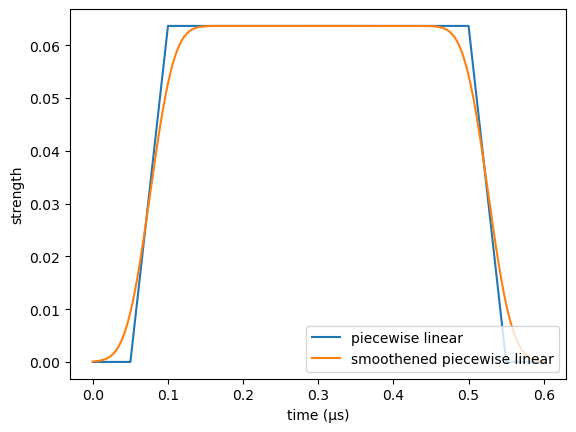

In [53]:
pulse_piecewise_linear = piecewise_linear(clocks = [0.0, 0.05, 0.1, 0.5, 0.55, T_max], values = [0, 0, 0.4, 0.4, 0, 0]);
pulse_smooth = smooth(pulse_piecewise_linear; kernel_radius = 0.02);

fig, ax = plt.subplots()
Bloqade.plot!(ax, pulse_piecewise_linear)
Bloqade.plot!(ax, pulse_smooth)
ax.set_ylabel("strength")
ax.legend(["piecewise linear", "smoothened piecewise linear"], loc = "lower right")
fig

Here, the function `smooth` takes a `kernel_radius` keyword parameter as the Gaussian kernel parameter.
With the new waveforms, we can define the loss function as follows:

In [54]:
function loss_piecewise_linear(atoms::AtomList, x::AbstractVector{T}) where {T}
    @assert length(x) == 3
    Ω_max = 4 * 2π
    Δ_start = -13 * 2π
    Δ_end = 11 * 2π
    Δ0 = 11 * 2π
    T_max = 0.6

    # the strength of the detunings at each step takes the optimizing x as their input
    Δs = smooth(
        piecewise_linear(
            clocks = T[0.0, 0.05, 0.2, 0.3, 0.4, 0.55, T_max],
            values = T[Δ_start, Δ_start, Δ0*x[1], Δ0*x[2], Δ0*x[3], Δ_end, Δ_end],
        );
        kernel_radius = 0.02,
    )
    Ωs = smooth(
        piecewise_linear(clocks = T[0.0, 0.05, 0.1, 0.5, 0.55, T_max], values = T[0, 0, Ω_max, Ω_max, 0, 0]);
        kernel_radius = 0.02,
    )

    hamiltonian = rydberg_h(atoms; Ω = Ωs, Δ = Δs)
    subspace = blockade_subspace(atoms, 7.5)
    prob = SchrodingerProblem(zero_state(Complex{T}, subspace), T_max, hamiltonian)
    emulate!(prob)
    return -rydberg_density_sum(prob.reg), prob.reg, Δs
end

x0 = [0.1, 0.8, 0.8]; # initial point for the optimization

Let us check the loss function with smoothened waveform with the initial point:

In [55]:
Δ_start = -13 * 2π
Δ_end = 11 * 2π
Δ0 = 11 * 2π
T_max = 0.6
Δ_initial = piecewise_linear(
    clocks = [0.0, 0.05, 0.2, 0.3, 0.4, 0.55, T_max],
    values = [Δ_start, Δ_start, Δ0 * x0[1], Δ0 * x0[2], Δ0 * x0[3], Δ_end, Δ_end],
)

rydberg_density, reg2, Δ_initial_smooth = loss_piecewise_linear(atoms, x0)
rydberg_density

-3.892595155083945

And plot the smoothened waveform:

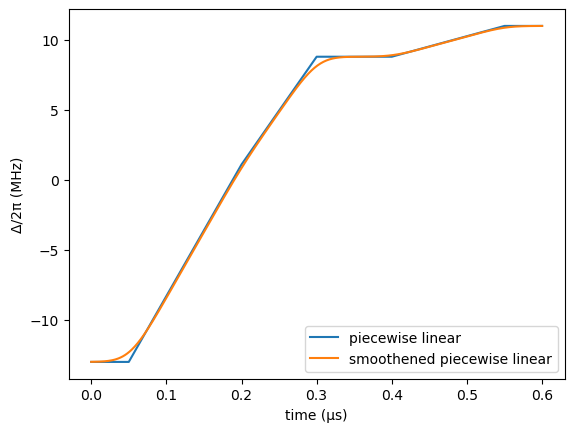

In [56]:
fig, ax = plt.subplots()
Bloqade.plot!(ax, Δ_initial)
Bloqade.plot!(ax, Δ_initial_smooth)
ax.set_ylabel("Δ/2π (MHz)")
ax.legend(["piecewise linear", "smoothened piecewise linear"], loc = "lower right")
fig

Let's plot the distribution:

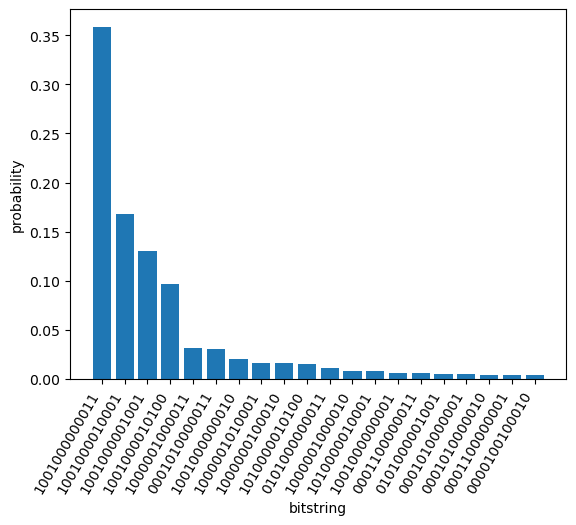

In [57]:
bitstring_hist(reg2; nlargest = 20)

The performance of the algorithm is quite good.
Again, let us use the `NelderMead` optimizer to optimize the loss function:

In [58]:
optresult = Optim.optimize(x -> loss_piecewise_linear(atoms, x)[1], x0)

rydberg_density_final, reg_final, Δ_final = loss_piecewise_linear(atoms, optresult.minimizer)
rydberg_density_final

-3.978139446307858

One can see the mean MIS size can be further improved to a value close to the size of the MIS,
which means there is a substantial probability for measuring an MIS state.

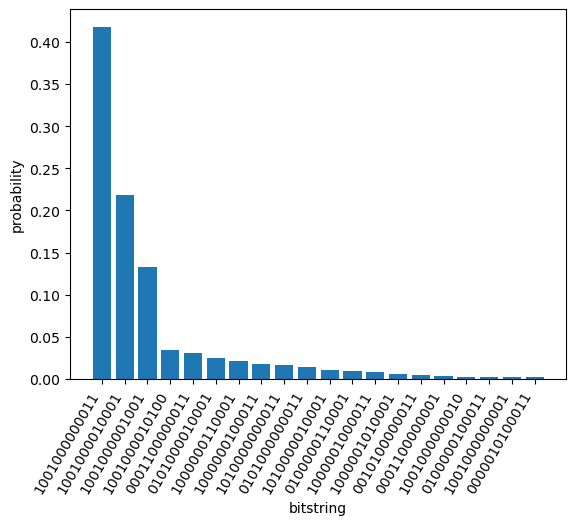

In [59]:
bitstring_hist(reg_final; nlargest = 20)

We can also plot out the final optimized waveform for Δ
and compare with the initial waveform:

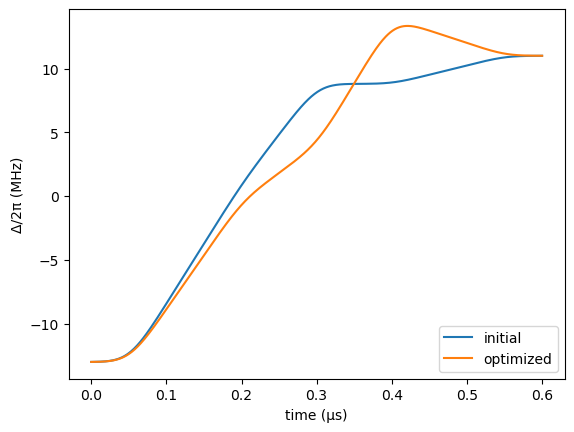

In [60]:
fig, ax = plt.subplots()
Bloqade.plot!(ax, Δ_initial_smooth)
Bloqade.plot!(ax, Δ_final)
ax.set_ylabel("Δ/2π (MHz)")
ax.legend(["initial", "optimized"], loc = "lower right")
fig